# Simulation study CE vs. EIS bias/variance/rho

## imports

In [1]:
from jax import vmap
import jax.numpy as jnp
import jax.random as jrn
from functools import partial
from jaxtyping import Array, Float

import matplotlib.pyplot as plt

from isssm.lcssm import nb_lcssm, simulate_lcssm
from isssm.mode_estimation import mode_estimation
from isssm.modified_efficient_importance_sampling import modified_efficient_importance_sampling
from isssm.ce_method import ce_cholesky_precision, marginals
from isssm.importance_sampling import ess_pct
from isssm.importance_sampling import lcssm_importance_sampling
from isssm.kalman import kalman, smoother

## simulation code

In [2]:
def eis_marginals(x0, A, Sigma, B, z, Omega):
    x_filt, Xi_filt, x_pred, Xi_pred = kalman(z, x0, Sigma, Omega, A, B)
    x_smooth, Xi_smooth = smoother(x_filt, Xi_filt, x_pred, Xi_pred, A)
    
    marg_means = x_smooth
    marg_vars = vmap(jnp.diag)(Xi_smooth)

    return marg_means, marg_vars

def eis_marginal_mean_var(key, N_eis, Y, x0, A, Sigma, B, dist, xi, z_la, Omega_la):
    key, subkey = jrn.split(key)
    z_eis, omega_eis = modified_efficient_importance_sampling(
        Y, x0, A, Sigma, B, xi, dist, z_la, Omega_la, 1, N_eis, subkey
    )

    return eis_marginals(x0, A, Sigma, B, z_eis, omega_eis)

def ce_marginal_mean_var(key, N_ce, Y, x0, A, Sigma, B, dist, xi, z_la, Omega_la):
    key, subkey = jrn.split(key)
    
    samples, log_weights = lcssm_importance_sampling(Y, x0, A, Sigma, B, dist, xi, z_la, Omega_la, N_ce, subkey)

    (diag, off_diag, mean), _, _ = ce_cholesky_precision(Y, x0, A, Sigma, B, xi, dist, samples, log_weights, 1, N_ce, subkey)

    return marginals(mean, diag, off_diag)

def bias_var(
    samples: Float[Array, "N ..."],
    true: Float[Array, "..."]
):
    bias_sr = (jnp.mean(samples, axis=0) - true)**2
    var = jnp.var(samples, axis=0)
    return bias_sr, var

def eis_bias_var(N_eis, key, N_mse, true_z, true_Omega, Y, x0, A, Sigma, B, dist, xi, z_la, Omega_la):
    key, *subkeys = jrn.split(key, N_mse+1)
    subkeys = jnp.array(subkeys)

    true_mean, true_var = eis_marginals(x0, A, Sigma, B, true_z, true_Omega)

    single_run = partial(eis_marginal_mean_var, Y=Y, N_eis=N_eis, x0=x0, A=A, Sigma=Sigma, B=B, dist=dist, xi=xi, z_la=z_la, Omega_la=Omega_la)
    marg_means, marg_vars = vmap(single_run)(subkeys)
        
    mean_bias, mean_var = bias_var(marg_means, true_mean)
    var_bias, var_var = bias_var(marg_vars, true_var)

    return (mean_bias, mean_var), (var_bias, var_var)

def ce_bias_var(N_ce, key, N_mse, true_mean, true_diag, true_off_diag, Y, x0, A, Sigma, B, dist, xi, z_la, Omega_la):
    key, *subkeys = jrn.split(key, N_mse+1)
    subkeys = jnp.array(subkeys)

    true_mean, true_var = marginals(true_mean, true_diag, true_off_diag)

    single_run = partial(ce_marginal_mean_var, N_ce=N_ce, Y=Y,x0=x0, A=A, Sigma=Sigma, B=B, dist=dist, xi=xi, z_la=z_la, Omega_la=Omega_la)

    marg_means, marg_vars = vmap(single_run)(subkeys)
        
    mean_bias, mean_var = bias_var(marg_means, true_mean)
    var_bias, var_var = bias_var(marg_vars, true_var)

    return (mean_bias, mean_var), (var_bias, var_var)

## setup

In [3]:
x0 = jnp.zeros(1)
n = 30
alpha = .5
A = alpha * jnp.tile(jnp.eye(1)[None,:,:], (n, 1, 1))
Sigma = (1 - alpha ** 2) * jnp.tile(jnp.eye(1)[None,:,:], (n + 1, 1, 1))

# NB observations 

nb_model = nb_lcssm(
    x0,
    A,
    Sigma,
    jnp.tile(jnp.eye(1)[None, :,:], (n + 1, 1, 1)),
    .1
)
x0, A, Sigma, B, dist, xi = nb_model

key = jrn.PRNGKey(342234)
key, subkey = jrn.split(key)
(X,), (Y,) = simulate_lcssm(*nb_model, 1, subkey)

X_smooth, z_la, Omega_la = mode_estimation(Y, x0, A, Sigma, B, dist, xi, X, 10)

N_true = int(1e6)
N_mse = 100
Ns = jnp.logspace(1,4,4).astype(jnp.int32)

/opt/homebrew/Caskroom/miniconda/base/envs/research/lib/python3.10/site-packages/tensorflow_probability/python/internal/backend/jax/random_generators.py:127: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'>  is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  samps = jaxrand.gamma(


## EIS simulation

In [4]:
key, subkey = jrn.split(key)
true_z_eis, true_omega_eis = modified_efficient_importance_sampling(
    Y, x0, A, Sigma, B, xi, dist, z_la, Omega_la, 1, N_true, subkey,
)

In [5]:
key, subkey = jrn.split(key)
single_N_run_eis = partial(
    eis_bias_var, 
    Y=Y, key=subkey, N_mse=N_mse, true_z=true_z_eis, true_Omega=true_omega_eis, x0=x0, A=A, Sigma=Sigma, B=B, dist=dist, xi=xi, z_la=z_la, Omega_la=Omega_la
)

results_eis = jnp.array([
    single_N_run_eis(N) for N in Ns
])


## CE simulation

In [6]:
key, subkey = jrn.split(key)
samples_la, log_weights_la = lcssm_importance_sampling(Y, x0, A, Sigma, B, dist, xi, z_la, Omega_la, N_true, subkey)
key, subkey = jrn.split(key)
(true_diag, true_off_diag, true_mu), (_, ce_log_weights), _ = ce_cholesky_precision(Y, x0, A, Sigma, B, xi, dist, samples_la, log_weights_la, 1, N_true, subkey)

In [7]:
key, subkey = jrn.split(key)
single_N_run_ce = partial(
    ce_bias_var, 
    Y=Y, key=subkey, N_mse=N_mse, true_mean=true_mu, true_diag=true_diag, true_off_diag=true_off_diag, x0=x0, A=A, Sigma=Sigma, B=B, dist=dist, xi=xi, z_la=z_la, Omega_la=Omega_la
)

results_ce = jnp.array([
    single_N_run_ce(N) for N in Ns
])

## inspect true solutions

In [8]:
_, log_weights_eis = lcssm_importance_sampling(Y, x0, A, Sigma, B, dist, xi, true_z_eis, true_omega_eis, N_true, subkey)
ess_pct(log_weights_la), ess_pct(ce_log_weights), ess_pct(log_weights_eis)

(Array(93.78924, dtype=float32),
 Array(98.269806, dtype=float32),
 Array(94.986275, dtype=float32))

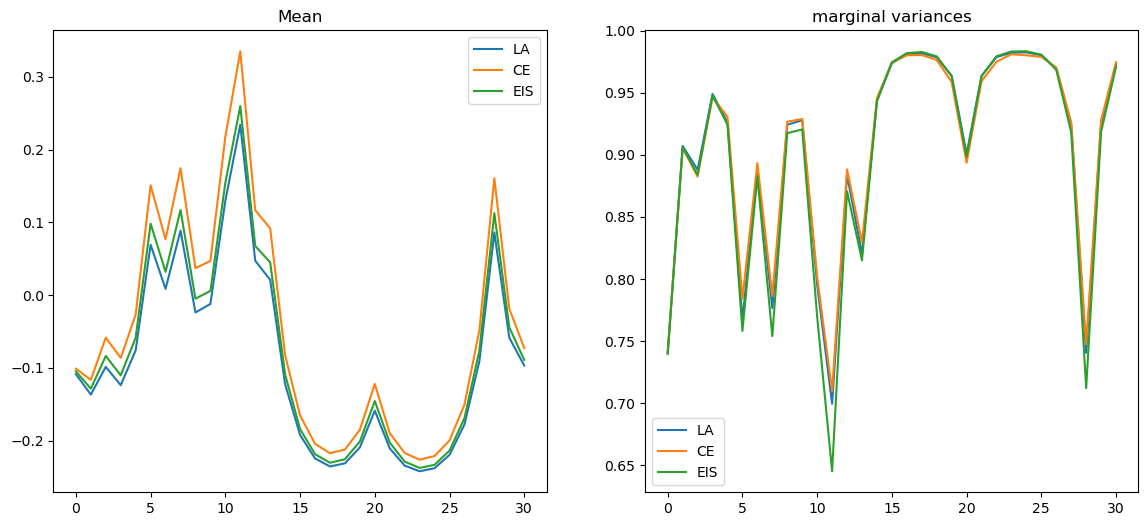

In [9]:
ce_true_mu, ce_true_var = marginals(true_mu, true_diag, true_off_diag)
eis_true_mu, eis_true_var = eis_marginals(x0, A, Sigma, B, true_z_eis, true_omega_eis)
la_mu, la_var = eis_marginals(x0, A, Sigma, B, z_la, Omega_la)


fig, axs = plt.subplots(1,2, figsize=(14,6))

axs[0].set_title("Mean")
axs[0].plot(la_mu[:,0], label="LA")
axs[0].plot(ce_true_mu[:,0], label="CE")
axs[0].plot(eis_true_mu[:,0], label="EIS")
axs[0].legend()
axs[1].set_title("marginal variances")
axs[1].plot(la_var[:,0], label="LA")
axs[1].plot(ce_true_var[:,0], label="CE")
axs[1].plot(eis_true_var[:,0], label="EIS")
axs[1].legend()
plt.show()

## simulation results

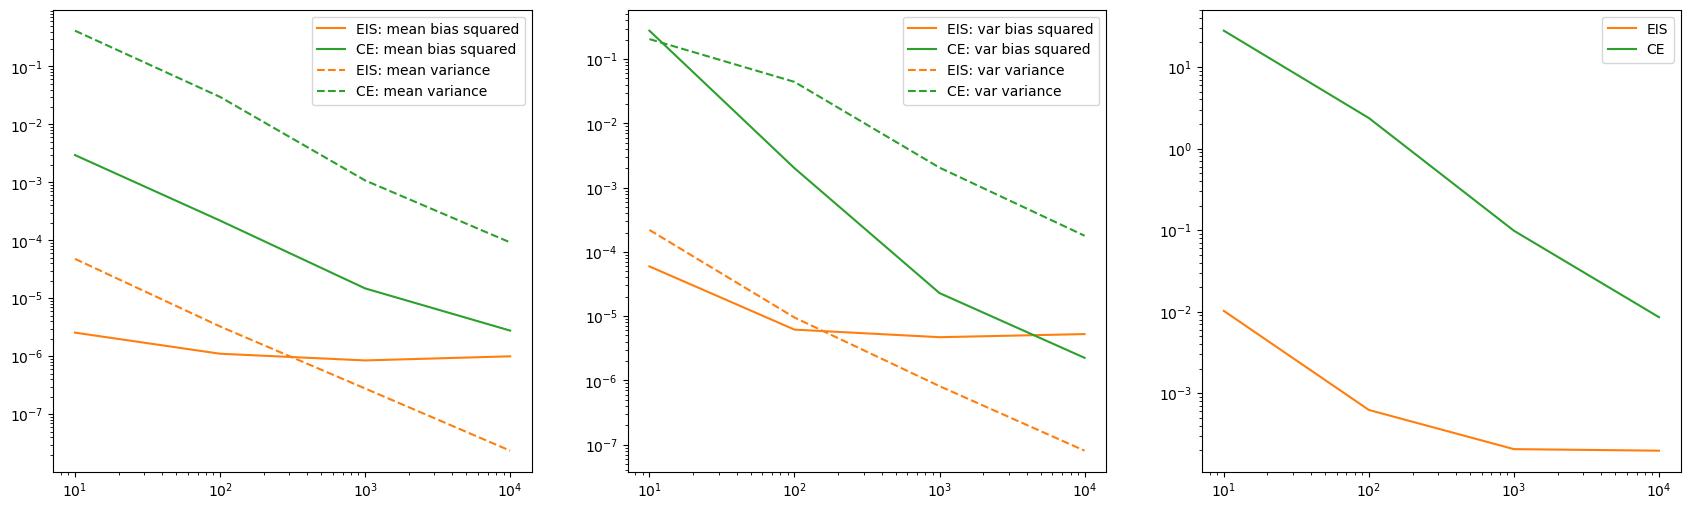

In [13]:
fig, axs = plt.subplots(1,3, figsize=(21,6))

average_bias_var_eis = results_eis.mean(axis=((-2, -1)))
average_bias_var_ce = results_ce.mean(axis=((-2, -1)))
mse_eis = results_eis.sum(axis=(-4, -3,-2,-1))
mse_ce = results_ce.sum(axis=(-4, -3,-2,-1))

axs[0].plot(Ns, average_bias_var_eis[:,0,0], label="EIS: mean bias squared", color="C1")
axs[0].plot(Ns, average_bias_var_ce[:,0,0], label="CE: mean bias squared", color="C2")
axs[0].plot(Ns, average_bias_var_eis[:,0,1], label="EIS: mean variance", color="C1", linestyle="--")
axs[0].plot(Ns, average_bias_var_ce[:,0,1], label="CE: mean variance", color="C2", linestyle="--")
axs[0].legend()
axs[0].set_xscale("log")
axs[0].set_yscale("log")

axs[1].plot(Ns, average_bias_var_eis[:,1,0], label="EIS: var bias squared", color="C1")
axs[1].plot(Ns, average_bias_var_ce[:,1,0], label="CE: var bias squared", color="C2")
axs[1].plot(Ns, average_bias_var_eis[:,1,1], label="EIS: var variance", color="C1", linestyle="--")
axs[1].plot(Ns, average_bias_var_ce[:,1,1], label="CE: var variance", color="C2", linestyle="--")
axs[1].legend()
axs[1].set_xscale("log")
axs[1].set_yscale("log")

axs[2].plot(Ns, mse_eis, label="EIS", color="C1")
axs[2].plot(Ns, mse_ce, label="CE", color="C2")

axs[2].set_xscale("log")
axs[2].set_yscale("log")
axs[2].legend()

plt.show()